
Steps

- Start with grid of size L
- Choose d random locations without trees
- Test grid with each variation
- Choose max yield 
- Record density, yield in dataset
- Initialize new grid
- Repeat until sum trees = LxL - 1 (LxL would be all trees burned)

In [1]:
import numpy as np
import pandas as pd
import math
import scipy.ndimage 
from itertools import product
import time


def get_labeled_grid(arr):
    lw, num = scipy.ndimage.label(arr, structure=[[0,1,0],
                                                  [1,1,1], 
                                                  [0,1,0]])
    area = scipy.ndimage.sum(arr, lw, index=np.arange(lw.max() + 1))
    return area, lw

def prob_spark(i, j, L):
    L = L/10
    i = i + 1
    j = j + 1
    return math.e**(-i/L)*math.e**(-j/L)

def normalized_prob(i, j, L, total):
    return prob_spark(i, j, L)/total

def get_prob_total(L):
     return sum([prob_spark(i_s - 1, j_s - 1, L) for i_s, j_s in product(range(1, L + 1), repeat=2)])

def total_burn_cell(i, j, label_grid, label_dict):
    groups = []
    coords = [(i, j), (i + 1, j), (i-1, j), (i, j + 1), (i, j -1)]
    for coord in coords:
        try:
            groups.append(label_grid[coord[0]][coord[1]])
        except:
            continue
    d_groups = set(groups)
    return sum([label_dict[grp] for grp in d_groups])

def make_probability_arr(L):
    probability_mat = np.zeros([L, L])
    prob_total = get_prob_total(L)
    for i, j in product(range(L), repeat=2):
        probability_mat[i, j] = normalized_prob(i, j, L, prob_total)
    return probability_mat

def get_spark_avg_yield(grid, prob_arr, L):
    label_dict, labeled_grid = get_labeled_grid(grid)
    burn_square = np.zeros([L, L])
    for i, j in product(range(L), repeat=2):
        burn_square[i, j] = total_burn_cell(i, j, labeled_grid, label_dict)
    burn_prob = burn_square*prob_arr
    average_yield = np.sum(grid)/(L*L) - np.sum(burn_prob)/(L*L)

    return average_yield

def get_sample_indexes(D, starting_arr):
    eligible_cells = np.where(starting_arr == 0)
    if D >= len(eligible_cells[0]):
            sampled_i = eligible_cells[0]
            sampled_j = eligible_cells[1]
    else:
        sampled_choices = np.random.randint(len(eligible_cells[0]), size=D)
        sampled_i = eligible_cells[0][sampled_choices]
        sampled_j = eligible_cells[1][sampled_choices]
    return sampled_i, sampled_j

def run_simulation(D, L):
    starting_arr = np.zeros([L, L])
    results = []
    prob_arr = make_probability_arr(L)
    global_max = 0
    best_arr = None
    print(f"starting {D}")
    for k in range(L*L):
        sampled_i, sampled_j = get_sample_indexes(D, starting_arr)
        max_yield = (0, 0, 0)
        for i, j in zip(sampled_i, sampled_j):
            starting_arr[i, j] = 1
            avg_yield = get_spark_avg_yield(starting_arr, prob_arr, L)
            if avg_yield > max_yield[2]:
                max_yield = (i, j, avg_yield)
            starting_arr[i, j] = 0
        tree_coverage = np.sum(starting_arr)/(L*L)
        #results[i] = {"tree_coverage": tree_coverage, "yield": max_yield[2], "D": D}
        results.append({"tree_coverage": tree_coverage, "yield": max_yield[2], "D": D})
        starting_arr[max_yield[0], max_yield[1]] = 1
        if max_yield[2] > global_max:
            best_arr = starting_arr.copy()
            global_max = max_yield[2]
    results_pd = pd.DataFrame.from_dict(results)
    return results_pd, best_arr

In [2]:
L = 64

Ds = [1, 2, 3, L, L*L]
#Ds = [3]

simulation_grid_results = [run_simulation(D, L) for D in Ds]

starting 1
starting 2
starting 3
starting 4096


In [3]:
simulation_grid_results_data =  [df[0] for df in simulation_grid_results]
simulation_grid_results_pd = pd.concat(simulation_grid_results_data)
simulation_grid_results_forest =  [obj[1] for obj in simulation_grid_results]

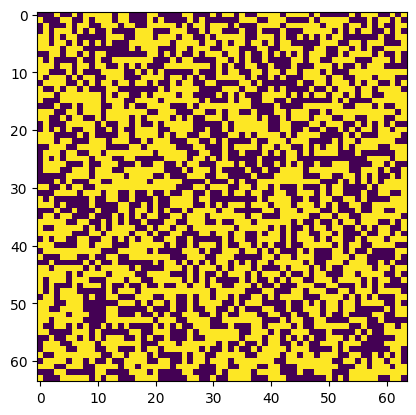

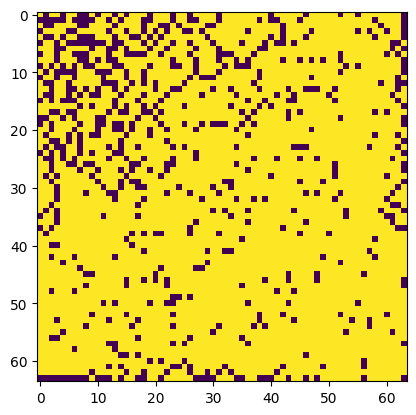

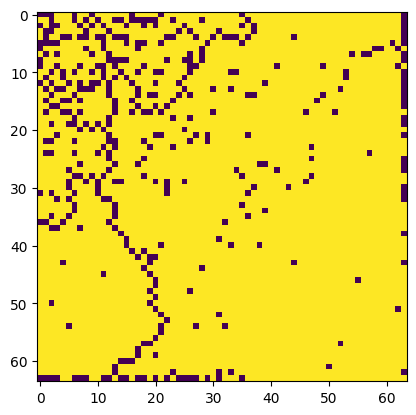

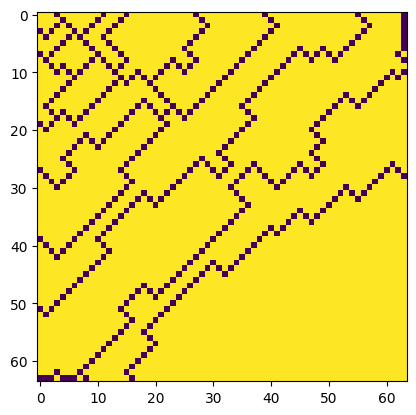

In [4]:
import matplotlib.pyplot as plt

for i in range(len(Ds)):
    plt.imshow(simulation_grid_results_forest[i])
    plt.show()

<AxesSubplot: xlabel='tree_coverage', ylabel='yield'>

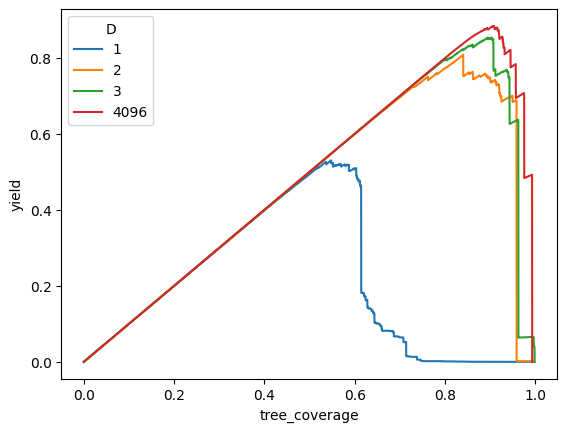

In [5]:
import pandas as pd
import seaborn as sns

simulation_grid_results_pd["D"] = simulation_grid_results_pd["D"].astype('category')

sns.lineplot(x = "tree_coverage", y = "yield", hue = "D", data = simulation_grid_results_pd)

In [6]:
from scipy.stats import rankdata

labeled_max_yield = [get_labeled_grid(grid) for grid in simulation_grid_results_forest]
rank_count = [(rankdata(-label[0][1:], method='ordinal'), label[0][1:]) for label in labeled_max_yield]
rank_count_df = [pd.DataFrame({"rank": data[0], "size": data[1], "D": D}) for data, D in zip(rank_count, Ds)]
rank_count_df = pd.concat(rank_count_df)
rank_count_df["rank"] = rank_count_df["rank"].apply(lambda x: math.log10(x))
rank_count_df["size"] = rank_count_df["size"].apply(lambda x: math.log10(x))

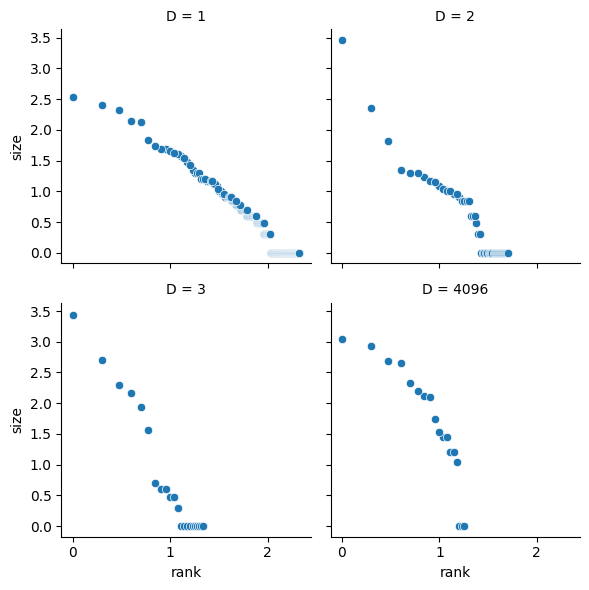

In [7]:
g = sns.FacetGrid(rank_count_df, col="D", col_wrap=2)
g.map(sns.scatterplot, "rank", "size")

In [8]:
def run_simulation_log_each_density(L, density_steps):
    D = L*L
    current_arr = np.zeros([L, L])
    prob_arr = make_probability_arr(L)
    density_sample = []
    print(f"starting {D}")
    for k in range(L*L):
        sampled_i, sampled_j = get_sample_indexes(D, current_arr)
        max_yield = (0, 0, 0)
        for i, j in zip(sampled_i, sampled_j):
            current_arr[i, j] = 1
            avg_yield = get_spark_avg_yield(current_arr, prob_arr, L)
            if avg_yield > max_yield[2]:
                max_yield = (i, j, avg_yield)
            current_arr[i, j] = 0
        current_arr[max_yield[0], max_yield[1]] = 1
        tree_coverage = np.sum(current_arr)/(L*L)
        if k in density_steps:
            print(f"logging {k} for density {tree_coverage}")
            density_sample.append(current_arr.copy())
    return density_sample

In [9]:
L = 64

densities_to_sample =  np.arange(0.1, 1, .10)
steps_to_sample = [round(dens*(L*L)) for dens in densities_to_sample]

density_samples_L2 = run_simulation_log_each_density(L, steps_to_sample)

starting 4096


In [ ]:
from scipy.stats import rankdata

labeled_max_yield_L2 = [get_labeled_grid(grid) for grid in density_samples_L2]
rank_count_L2 = [(rankdata(-label[0][1:], method='ordinal'), label[0][1:]) for label in labeled_max_yield_L2]
rank_count_df_L2 = [pd.DataFrame({"rank": data[0], "size": data[1], "density": dens}) for data, dens in zip(rank_count_L2, densities_to_sample)]
rank_count_df_L2 = pd.concat(rank_count_df_L2)
rank_count_df_L2["rank"] = rank_count_df_L2["rank"].apply(lambda x: math.log10(x))
rank_count_df_L2["size"] = rank_count_df_L2["size"].apply(lambda x: math.log10(x))
rank_count_df_L2["density"] = rank_count_df_L2["density"].astype("category")

<AxesSubplot: xlabel='rank', ylabel='size'>

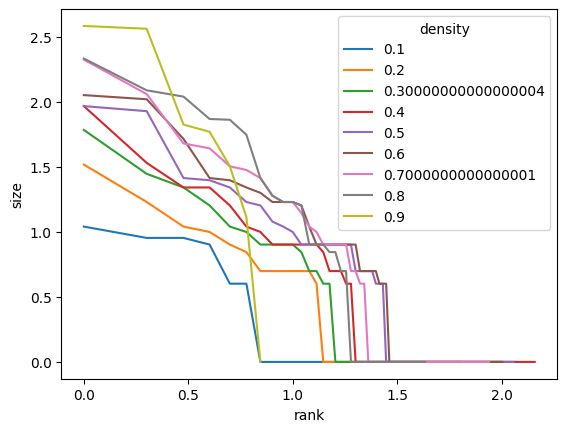

In [ ]:
sns.lineplot(x = "rank", y= "size", hue = "density", data = rank_count_df_L2)

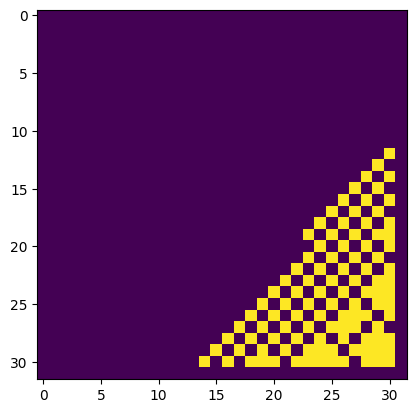

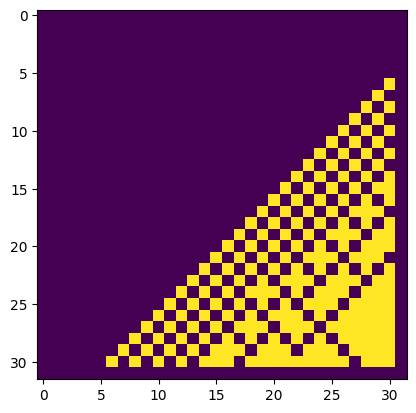

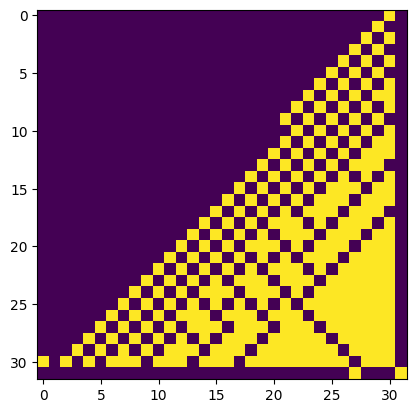

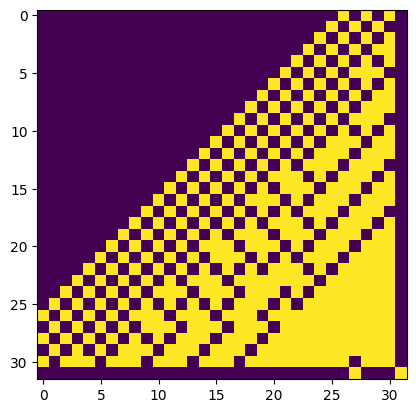

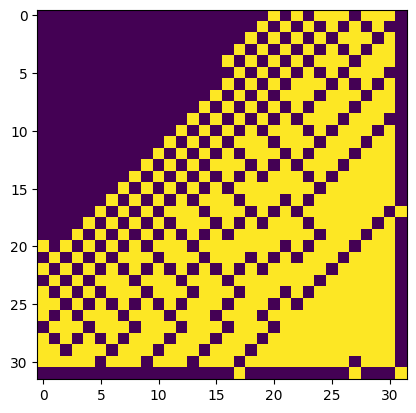

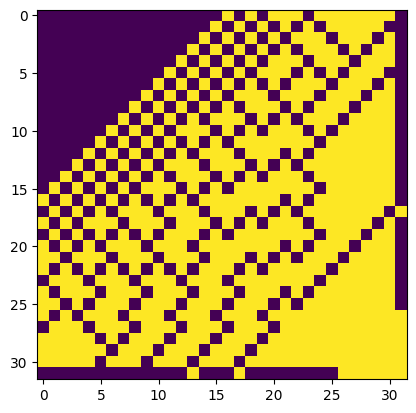

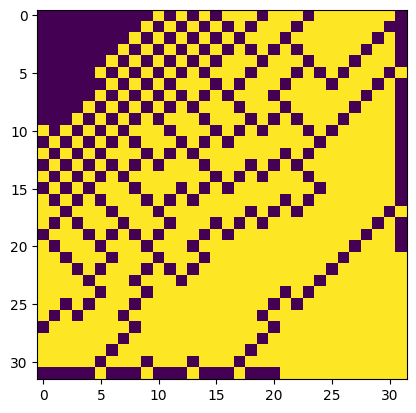

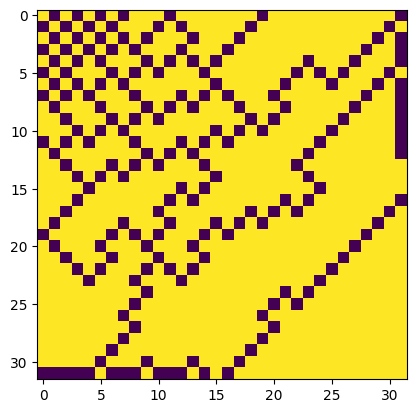

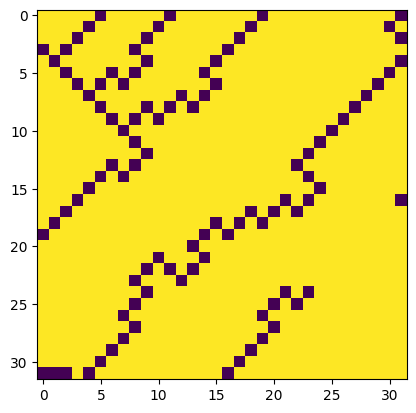

In [ ]:
import matplotlib.pyplot as plt

for grid in density_samples_L2:
    plt.imshow(grid)
    plt.show()